<a href="https://colab.research.google.com/github/rameshnatarajanus/Sentinel-5p-NO2-data-analysis/blob/main/Notebooks/Earth_Engine_training_data_Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Copyright 2023 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/rameshnatarajanus/Sentinel-5p-NO2-data-analysis/blob/main/Notebooks/Earth_Engine_training_data_Sentinel2.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/rameshnatarajanus/Sentinel-5p-NO2-data-analysis/blob/main/Notebooks/Earth_Engine_training_data_Sentinel2.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>



# Download training patches from Earth Engine

This notebook shows how to get patches of Sentinel-2 imagery from Earth Engine for training ML models.  

Specifically, use `computePixels` calls to obtain the image patches and export them to a file system.

In future, these calls will be made in parallel to quickly and efficiently write a TFRecord file for subsequent machine learning.

We have not yet identified the right threshold value of CLOUD_PIXEL_PERCENTAGE to filter the images.  

## Imports

In [3]:
from google.colab import auth
from google.api_core import retry
from IPython.display import HTML, Image
from matplotlib import pyplot as plt
from numpy.lib import recfunctions as rfn

import concurrent
import ee
import geemap
import google
import io
import multiprocessing
import numpy as np
import requests
import tensorflow as tf
import pandas as pd
import math


## Authentication and initialization

Use the Colab auth widget to get credentials, then use them to initialize Earth Engine.  During initialization, be sure to specify a project and Earth Engine's [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume), in order to make automated requests.

In [4]:
# REPLACE WITH YOUR PROJECT!
PROJECT = 'yeshiva-com-4010-spring-2024'

In [5]:
auth.authenticate_user()

In [6]:
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

## Sentinel-2 data image time series at a given location

## Image retrieval functions

This section includes functions to obtain a time series of Sentinel-2 images and get a pacth of pixels from each image, centered on the provided coordinates, as either as a time series of numpy arrays or a time series of JPEG thumbnails (for visualization).  The JPEG thumbnails are plotted as a filmstrip



Initial investigation of Sentinel-2 Image data.

The availability of images over the ROI seem to come 5 days apart, which is consistent with the published revisit frequency.

There are multiple non-overlapping images on a given day which have some fraction of pixels covering  the ROI. Basically all of these images can be combined into a single image.

At this point we leave out  the images with High CLOUDY_PIXEL_PERCENTAGE ( > 20%).

In [7]:
int_to_date =  lambda x: ee.Date(x).format().slice(0,10)

def get_s2_ImageSeries(roi, start_date, end_date, cloud_pixel_percentage_max):
  """Get the Sentinel-2 images for the roi and time range [start_date, end_date]."""


  # function for obtaining the median composite over all the images on a date

  def image_mediancomposite_by_date(date):
    return ee.ImageCollection('COPERNICUS/S2_HARMONIZED')\
    .filterDate(ee.Date(date), ee.Date(date).advance(1, 'day'))\
    .select(['B4', 'B3', 'B2'])\
    .median()\
    .set('system:time_start', ee.Date(date).millis())

  # first get all the images between start and end date (filter out cloudy images,
  # which may leave holes when the images are composited)

  images = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')\
      .filterBounds(roi)\
      .filterDate(start_date, end_date)\
      .filter(f'CLOUDY_PIXEL_PERCENTAGE < {cloud_pixel_percentage_max}')\
      .select(['B4', 'B3', 'B2'])

  # find the dates on which images were available (should be once every 5 days)

  image_dates = ee.List.distinct(images.aggregate_array('system:time_start').map(int_to_date))

  # over each date for which images were available composite the images

  images = ee.ImageCollection(
        ee.List(image_dates)\
        .map(image_mediancomposite_by_date)
    )

  # return the composite image for each date

  return images



The region of interest is a 640m square region centered on the coordinates for the New Madrid Power Plant in MO (USA)



In [8]:


TEST_COORDS= [-89.5617, 36.5147]


TEST_ROI = ee.Geometry.Polygon([
            [-89.55822460874718, 36.517658638905466],
            [-89.55803477773051, 36.511894698221795],
            [-89.56517512701873, 36.51174126880392],
            [-89.5653654865036, 36.5175051774071],
          ])

# last date is non-inclusive

TEST_DATE_START = ee.Date('2023-01-01')
TEST_DATE_END = ee.Date('2024-01-01')

# restrict to non-cloudy or partially cloudy images  by adjusting value to between 0 to 100

CLOUDY_PIXEL_PERCENTAGE_MAX = 100

Get the collection of composited images between start_datate and end_date over the roi.  There will only be 1 image per date for each of the dates where the roi coverage is obtained from sentinel-2

In [9]:

images = get_s2_ImageSeries(TEST_ROI, TEST_DATE_START, TEST_DATE_END, CLOUDY_PIXEL_PERCENTAGE_MAX)
print(f"total number of images: {images.aggregate_count('system:time_start').getInfo()}")

print("\nImage Count by Date:")
image_dates = ee.List(images.aggregate_array('system:time_start')).map(int_to_date).getInfo()
display(pd.DataFrame(image_dates).groupby(image_dates).agg(['count']).head(20))



total number of images: 66

Image Count by Date:


,0
,count
2023-01-05,1
2023-01-10,1
2023-01-15,1
2023-01-20,1
2023-01-25,1
2023-02-04,1
2023-02-09,1
2023-02-14,1
2023-02-19,1


In [10]:
# Visualize the aggregate data  which takes a few minutes to compute and render
import geemap

images_list = images.toList(12)


visParams = {
    'min': 0,
    'max': 5000,
    };

zoom_level = 15
Map = geemap.Map(zoom_start = zoom_level, max_zoom=zoom_level, min_zoom=zoom_level,
                                          min_lat=19, max_lat=65,min_lot=-160, max_lot=-70)
Map.addLayer(TEST_ROI,{},'ROI')

for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().getInfo()
  print(time)
  Map.addLayer(image,visParams,f'image-{time}')
Map.setCenter(*TEST_COORDS, 8)
Map.addLayerControl()

Map

2023-01-05T00:00:00
2023-01-10T00:00:00
2023-01-15T00:00:00


2023-01-20T00:00:00


2023-01-25T00:00:00


2023-02-04T00:00:00
2023-02-09T00:00:00


2023-02-14T00:00:00
2023-02-19T00:00:00


2023-02-24T00:00:00
2023-03-01T00:00:00
2023-03-06T00:00:00


Map(center=[36.5147, -89.5617], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

Gallery of reduced image band array data over a region of interest
This section includes functions to obtain a time series of reduced image band array data for visualization as a image gallery

Obtain image patches using computePixels over the region of interest

The functions that request patches are retriable and you can do that automatically by decorating the functions with Retry.

In [11]:

# Output resolution in meters.
SCALE = 10

# Pre-compute a geographic coordinate system.
proj = ee.Projection('EPSG:4326').atScale(SCALE).getInfo()
PATCH_SIZE = 128
# Get scales in degrees out of the transform.
SCALE_X = proj['transform'][0]
SCALE_Y = -proj['transform'][4]

# Offset to the upper left corner.
OFFSET_X = -SCALE_X * PATCH_SIZE / 2
OFFSET_Y = -SCALE_Y * PATCH_SIZE / 2

# Request template.
REQUEST = {
      'fileFormat': 'NPY',
      'grid': {
          'dimensions': {
              'width': PATCH_SIZE,
              'height': PATCH_SIZE
          },
          'affineTransform': {
              'scaleX': SCALE_X,
              'shearX': 0,
              'shearY': 0,
              'scaleY': SCALE_Y,
          },
          'crsCode': proj['crs']
      }
  }

@retry.Retry()
def get_patch(coords, image):
  """Get a patch centered on the coordinates, as a numpy array."""
  request = dict(REQUEST)
  request['expression'] = image
  request['grid']['affineTransform']['translateX'] = coords[0] + OFFSET_X
  request['grid']['affineTransform']['translateY'] = coords[1] + OFFSET_Y
  return np.load(io.BytesIO(ee.data.computePixels(request)))



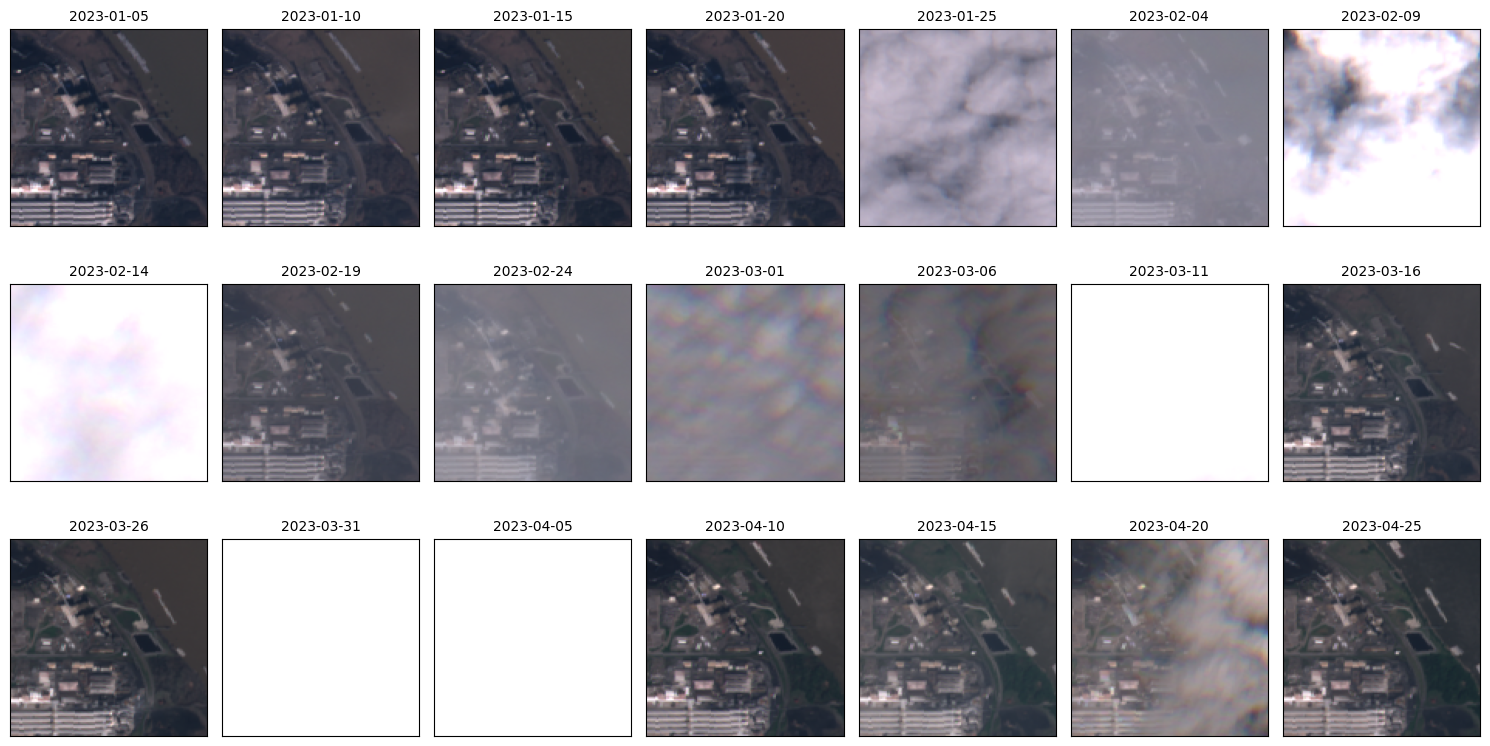

In [12]:
# avoid warning log messages from matplotlib
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)


# number of images to display
images_list = images.toList(21)

cols = 7
rows = math.ceil(images_list.size().getInfo()/cols)

fig = plt.figure(figsize=(15, 8))
for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().slice(0,10).getInfo()
  np_array = get_patch(TEST_COORDS, image)
  ax = fig.add_subplot(rows, cols, index+1)
  display_array = rfn.structured_to_unstructured(np_array[['B4', 'B3', 'B2']])/5000
  plt.imshow(display_array)
  ax.set_title(time, fontsize=10)
  ax.axes.xaxis.set_ticks([])
  ax.axes.yaxis.set_ticks([])
plt.tight_layout()
plt.show()



logger.setLevel(old_level)